# Gaussian Mixture Model (GMM) for Sequential Hand Pose Clustering

This notebook implements GMM clustering where **21 consecutive rows represent one hand pose** (21 landmarks per frame).

## Data Structure
- Each frame has 21 hand landmarks
- Each landmark has X, Y, Z coordinates
- Therefore, 21 consecutive rows = 1 hand pose = 63-dimensional vector (21 × 3)

## Requirements Installation

```bash
pip install numpy pandas scikit-learn matplotlib
```


In [46]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
import pandas as pd


## Step 1: Load and Reshape Data

Load the dataset and reshape it so that 21 consecutive rows become one sample (one hand pose).


In [47]:
# Load the dataset
print("Loading hand landmark dataset...")
dataset = pd.read_csv('combined.csv')

# Extract X, Y, Z coordinates
coordinates = dataset[['X', 'Y', 'Z']].values

print(f"Total rows in dataset: {len(coordinates):,}")
print(f"Dataset shape: {coordinates.shape}")


Loading hand landmark dataset...
Total rows in dataset: 2,016,000
Dataset shape: (2016000, 3)


In [48]:
# Reshape data: 21 consecutive rows = 1 hand pose
LANDMARKS_PER_FRAME = 21

# Calculate number of complete frames
n_frames = len(coordinates) // LANDMARKS_PER_FRAME

# Trim to have complete frames only
coordinates_trimmed = coordinates[:n_frames * LANDMARKS_PER_FRAME]

# Reshape: (n_frames, 21, 3) -> (n_frames, 63)
hand_poses = coordinates_trimmed.reshape(n_frames, LANDMARKS_PER_FRAME * 3)

print(f"\nReshaped data:")
print(f"Number of frames (hand poses): {n_frames:,}")
print(f"Features per frame: {hand_poses.shape[1]} (21 landmarks × 3 coordinates)")
print(f"Hand poses shape: {hand_poses.shape}")



Reshaped data:
Number of frames (hand poses): 96,000
Features per frame: 63 (21 landmarks × 3 coordinates)
Hand poses shape: (96000, 63)


## Step 2: Data Preprocessing

Remove frames with all zeros (no hand detected) and normalize the data.


In [49]:
# Remove frames with all zeros (no hand detected)
non_zero_mask = ~np.all(hand_poses == 0, axis=1)
hand_poses_clean = hand_poses[non_zero_mask]

print(f"Frames with hand detected: {len(hand_poses_clean):,}")
print(f"Frames removed (no hand): {n_frames - len(hand_poses_clean):,}")
print(f"Clean data shape: {hand_poses_clean.shape}")


Frames with hand detected: 60,024
Frames removed (no hand): 35,976
Clean data shape: (60024, 63)


## Step 3: Apply GMM Clustering

Fit GMM model on the hand pose sequences. Each cluster represents a different hand gesture or pose.


In [61]:
# Create GMM model with 8 components
n_components = 8
gmm = GaussianMixture(n_components, covariance_type='full', init_params='k-means++', n_init=20, max_iter=200)

print(f"\nFitting GMM with {n_components} components...")
print("This may take a few minutes...")
gmm.fit(hand_poses_clean)

# Predict cluster labels
pose_labels = gmm.predict(hand_poses_clean)

print("\nGMM clustering completed!")
print(f"Converged: {gmm.converged_}")



Fitting GMM with 8 components...
This may take a few minutes...

GMM clustering completed!
Converged: True


## Step 4: Evaluate Clustering Performance


In [62]:
# Calculate evaluation metrics
sil_score = silhouette_score(hand_poses_clean, pose_labels)
#dbi_score = davies_bouldin_score(hand_poses_clean, pose_labels)
#chi_score = calinski_harabasz_score(hand_poses_clean, pose_labels)

# Print results
print("=" * 70)
print("GMM Clustering Evaluation (Sequential Hand Poses)")
print("=" * 70)
print(f"Number of components: {n_components}")
print(f"Total hand poses clustered: {len(hand_poses_clean):,}")
print(f"Feature dimensions: {hand_poses_clean.shape[1]} (21 landmarks × 3 coords)")
print("-" * 70)
print(f"Silhouette Score: {sil_score:.6f} (higher is better, range: -1 to 1)")
#print(f"Davies-Bouldin Index (DBI): {dbi_score:.6f} (lower is better)")
#print(f"Calinski-Harabasz Index (CHI): {chi_score:.6f} (higher is better)")
print("=" * 70)


GMM Clustering Evaluation (Sequential Hand Poses)
Number of components: 8
Total hand poses clustered: 60,024
Feature dimensions: 63 (21 landmarks × 3 coords)
----------------------------------------------------------------------
Silhouette Score: 0.343577 (higher is better, range: -1 to 1)


## Step 5: Cluster Distribution Analysis



Cluster Distribution:
--------------------------------------------------
Cluster 0: 6,000 poses (10.00%)
Cluster 1: 5,038 poses (8.39%)
Cluster 2: 5,760 poses (9.60%)
Cluster 3: 6,244 poses (10.40%)
Cluster 4: 7,276 poses (12.12%)
Cluster 5: 11,990 poses (19.98%)
Cluster 6: 12,000 poses (19.99%)
Cluster 7: 5,716 poses (9.52%)


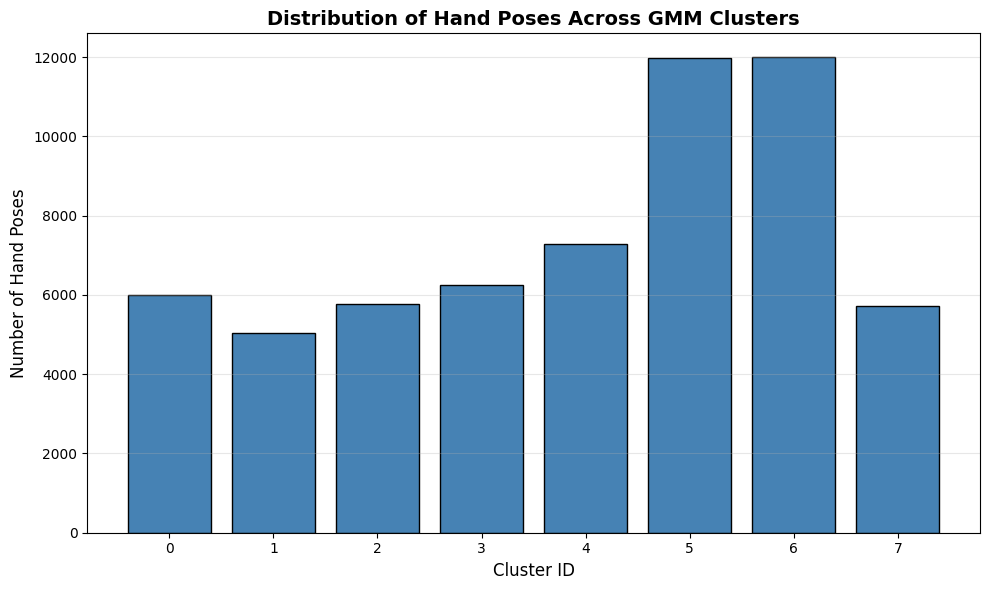

In [63]:
# Analyze cluster distribution
print("\nCluster Distribution:")
print("-" * 50)
for i in range(n_components):
    count = (pose_labels == i).sum()
    percentage = 100 * count / len(pose_labels)
    print(f"Cluster {i}: {count:,} poses ({percentage:.2f}%)")

# Plot cluster distribution
plt.figure(figsize=(10, 6))
unique, counts = np.unique(pose_labels, return_counts=True)
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Hand Poses', fontsize=12)
plt.title('Distribution of Hand Poses Across GMM Clusters', fontsize=14, fontweight='bold')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('GMM_sequential_cluster_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 6: Visualize Clusters using PCA

Since we have 63 dimensions, we'll use PCA to reduce to 2D/3D for visualization.


In [64]:
# Apply PCA for visualization
print("\nApplying PCA for visualization...")
pca_3d = PCA(n_components=3, random_state=42)
poses_3d = pca_3d.fit_transform(hand_poses_clean)

print(f"Explained variance ratio (3 components): {pca_3d.explained_variance_ratio_}")
print(f"Total explained variance: {pca_3d.explained_variance_ratio_.sum():.4f}")



Applying PCA for visualization...
Explained variance ratio (3 components): [0.62937297 0.22265851 0.06193386]
Total explained variance: 0.9140


In [65]:
# Sample data for visualization if too large
sample_size = min(60000, len(poses_3d))
if len(poses_3d) > sample_size:
    print(f"Sampling {sample_size:,} poses for visualization...")
    sample_indices = np.random.choice(len(poses_3d), sample_size, replace=False)
    poses_3d_sample = poses_3d[sample_indices]
    labels_sample = pose_labels[sample_indices]
else:
    poses_3d_sample = poses_3d
    labels_sample = pose_labels

# Transform GMM centers to PCA space
gmm_centers_3d = pca_3d.transform(gmm.means_)


Sampling 60,000 poses for visualization...



Visualization saved as: GMM_sequential_clustering_visualization.png


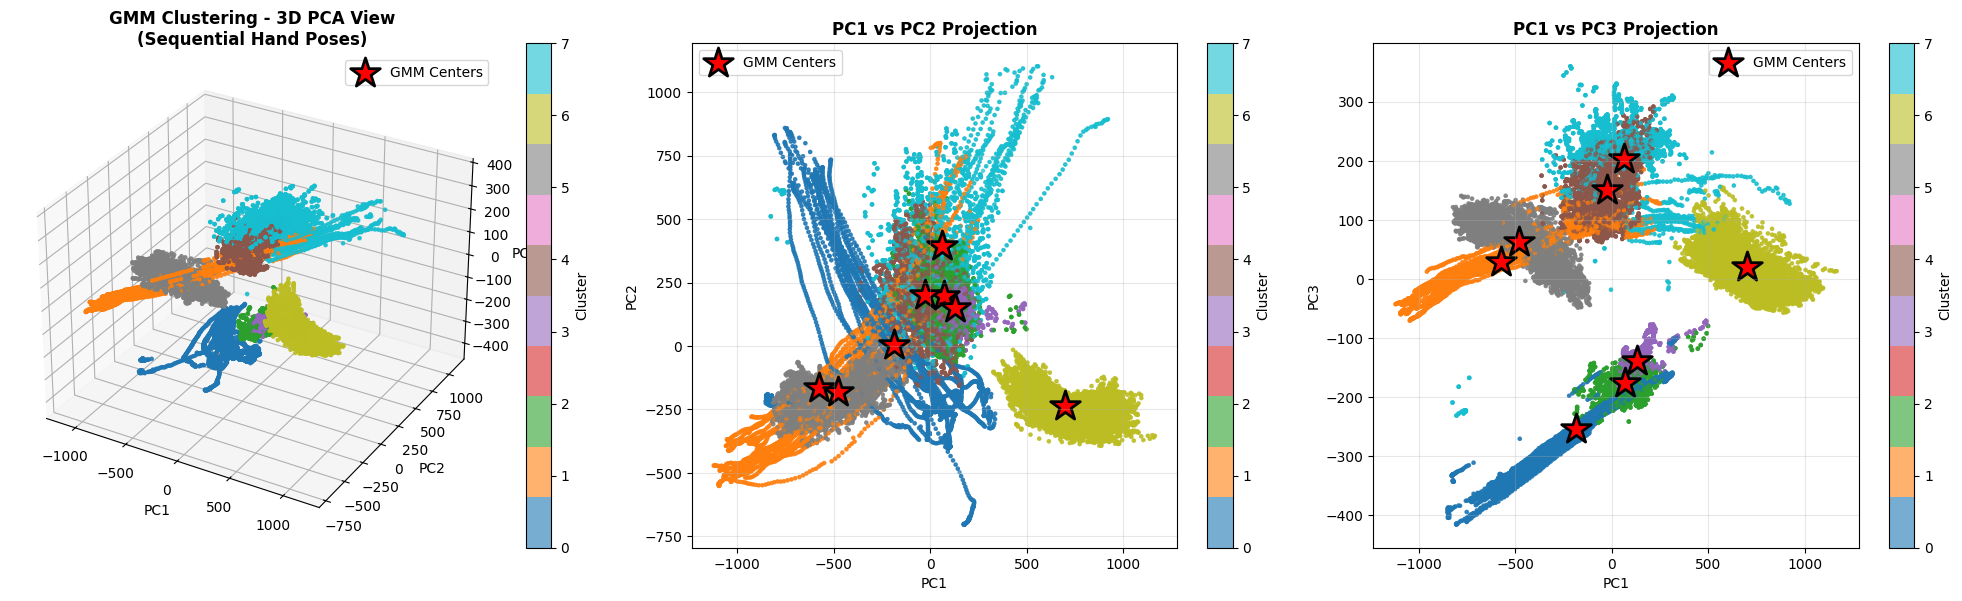

In [66]:
# Create 3D visualization
fig = plt.figure(figsize=(20, 6))

# 1. 3D Scatter Plot
ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(poses_3d_sample[:, 0], poses_3d_sample[:, 1], poses_3d_sample[:, 2],
                     c=labels_sample, cmap='tab10', s=5, alpha=0.6)

# Plot GMM centers
ax1.scatter(gmm_centers_3d[:, 0], gmm_centers_3d[:, 1], gmm_centers_3d[:, 2],
           s=500, c='red', marker='*', label='GMM Centers', 
           edgecolors='black', linewidths=2)

ax1.set_xlabel('PC1', fontsize=10)
ax1.set_ylabel('PC2', fontsize=10)
ax1.set_zlabel('PC3', fontsize=10)
ax1.set_title('GMM Clustering - 3D PCA View\n(Sequential Hand Poses)', fontsize=12, fontweight='bold')
ax1.legend()
plt.colorbar(scatter, ax=ax1, label='Cluster')

# 2. PC1 vs PC2
ax2 = fig.add_subplot(132)
scatter2 = ax2.scatter(poses_3d_sample[:, 0], poses_3d_sample[:, 1],
                      c=labels_sample, cmap='tab10', s=5, alpha=0.6)
ax2.scatter(gmm_centers_3d[:, 0], gmm_centers_3d[:, 1],
           s=500, c='red', marker='*', label='GMM Centers',
           edgecolors='black', linewidths=2)
ax2.set_xlabel('PC1', fontsize=10)
ax2.set_ylabel('PC2', fontsize=10)
ax2.set_title('PC1 vs PC2 Projection', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# 3. PC1 vs PC3
ax3 = fig.add_subplot(133)
scatter3 = ax3.scatter(poses_3d_sample[:, 0], poses_3d_sample[:, 2],
                      c=labels_sample, cmap='tab10', s=5, alpha=0.6)
ax3.scatter(gmm_centers_3d[:, 0], gmm_centers_3d[:, 2],
           s=500, c='red', marker='*', label='GMM Centers',
           edgecolors='black', linewidths=2)
ax3.set_xlabel('PC1', fontsize=10)
ax3.set_ylabel('PC3', fontsize=10)
ax3.set_title('PC1 vs PC3 Projection', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter3, ax=ax3, label='Cluster')

plt.tight_layout()
plt.savefig('GMM_sequential_clustering_visualization.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved as: GMM_sequential_clustering_visualization.png")
plt.show()


## Step 7: Map Back to Original Data

Create a mapping from the original row indices to cluster labels.


In [56]:
# Create label array for all original rows
# Each frame (21 rows) gets the same cluster label
row_labels = np.full(len(dataset), -1, dtype=np.int32)  # -1 for frames with no hand

# Map pose labels back to individual rows
clean_frame_idx = 0
for frame_idx in range(n_frames):
    if non_zero_mask[frame_idx]:
        # This frame has a hand detected
        start_row = frame_idx * LANDMARKS_PER_FRAME
        end_row = start_row + LANDMARKS_PER_FRAME
        row_labels[start_row:end_row] = pose_labels[clean_frame_idx]
        clean_frame_idx += 1

# Add to dataset
dataset['pose_cluster'] = row_labels

print(f"\nMapped {clean_frame_idx:,} hand poses back to {len(dataset):,} rows")
print(f"Rows with cluster assignment: {(row_labels >= 0).sum():,}")
print(f"Rows without hand (-1 label): {(row_labels == -1).sum():,}")



Mapped 60,024 hand poses back to 2,016,000 rows
Rows with cluster assignment: 1,260,504
Rows without hand (-1 label): 755,496


## Step 8: Save Results


In [67]:
# Save clustered dataset
output_file = 'combined_gmm_sequential_clustered.csv'
dataset.to_csv(output_file, index=False)
print(f"\nClustered dataset saved as: {output_file}")

# Save cluster statistics
stats = {
    'total_frames': n_frames,
    'frames_with_hand': len(hand_poses_clean),
    'n_components': n_components
    #'silhouette_score': sil_score,
    #'davies_bouldin_index': dbi_score,
    #'calinski_harabasz_index': chi_score
}

stats_df = pd.DataFrame([stats])
stats_df.to_csv('GMM_sequential_stats.csv', index=False)
print("Statistics saved as: GMM_sequential_stats.csv")

print("\n" + "="*70)
print("GMM Sequential Clustering Complete!")
print("="*70)



Clustered dataset saved as: combined_gmm_sequential_clustered.csv
Statistics saved as: GMM_sequential_stats.csv

GMM Sequential Clustering Complete!


## Summary

This notebook correctly treats the sequential nature of hand landmark data:
- Groups 21 consecutive rows as one hand pose
- Each pose is represented as a 63-dimensional vector
- GMM clusters similar hand poses together
- Each cluster potentially represents a distinct gesture or hand configuration
